# Прогнозирование стоимости поездок в такси Uber с помощью методов машинного обучения

Студент: Симонов Никита Алексеевич

Номер ИСУ: 265168

# Описание набора данных

Данные описывают поездки с такси "Uber" по всему миру.

Признак  | Описание
-------------------|--------------------
key       | Уникальный идентификатор поездки
fare_amount | Стоимость поездки в долларах США
pickup_datetime  | Временная метка подбора пассажиров
passenger_count   | Количество пассажиров
pickup_longitude & pickup_latitude   | Координаты места подбора пассажиров
pickup_longitude & pickup_latitude   | Координаты места высадки пассажиров


# Загрузка и предварительная обработка данных

Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Устновим недостающие библиотеки

In [2]:
!pip install seaborn
!pip install geopy

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip


Загрузим данные в датафрейм 

In [12]:
data = pd.read_csv("uber.csv")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


Посмотрим на данные

In [5]:
data.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,52:06.0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,04:56.0,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,45:00.0,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,22:21.0,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,47:00.0,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


Удалим первые два столбца

In [6]:
data = data.drop(['Unnamed: 0'], axis=1)
data = data.drop(['key'], axis=1)

In [8]:
data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


Посмотрим на статистику, посчитанную по данному набору данных

In [10]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,196032.000000,196032.000000,196032.000000,196031.000000,196031.000000,196032.000000
mean,11.343074,-73.930056,40.705592,-73.917108,40.688590,1.685220
std,9.799590,5.449354,5.426830,8.518210,3.994266,1.388152
min,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,6.000000,-73.992268,40.736396,-73.991592,40.735265,1.000000
50%,8.500000,-73.982101,40.753287,-73.980521,40.753726,1.000000
75%,12.500000,-73.968313,40.767542,-73.965316,40.768326,2.000000
max,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


Видно, что наблюдаются выбросы, например в минимальных значениях стоимости (отрицательная стоимость), а также в минимальных и максимальных значениях долготы и широты. В других столбцах также наблюдаются выбросы в максимальных значениях.

Построим boxplot, чтобы посмотреть на выбросы

<AxesSubplot:>

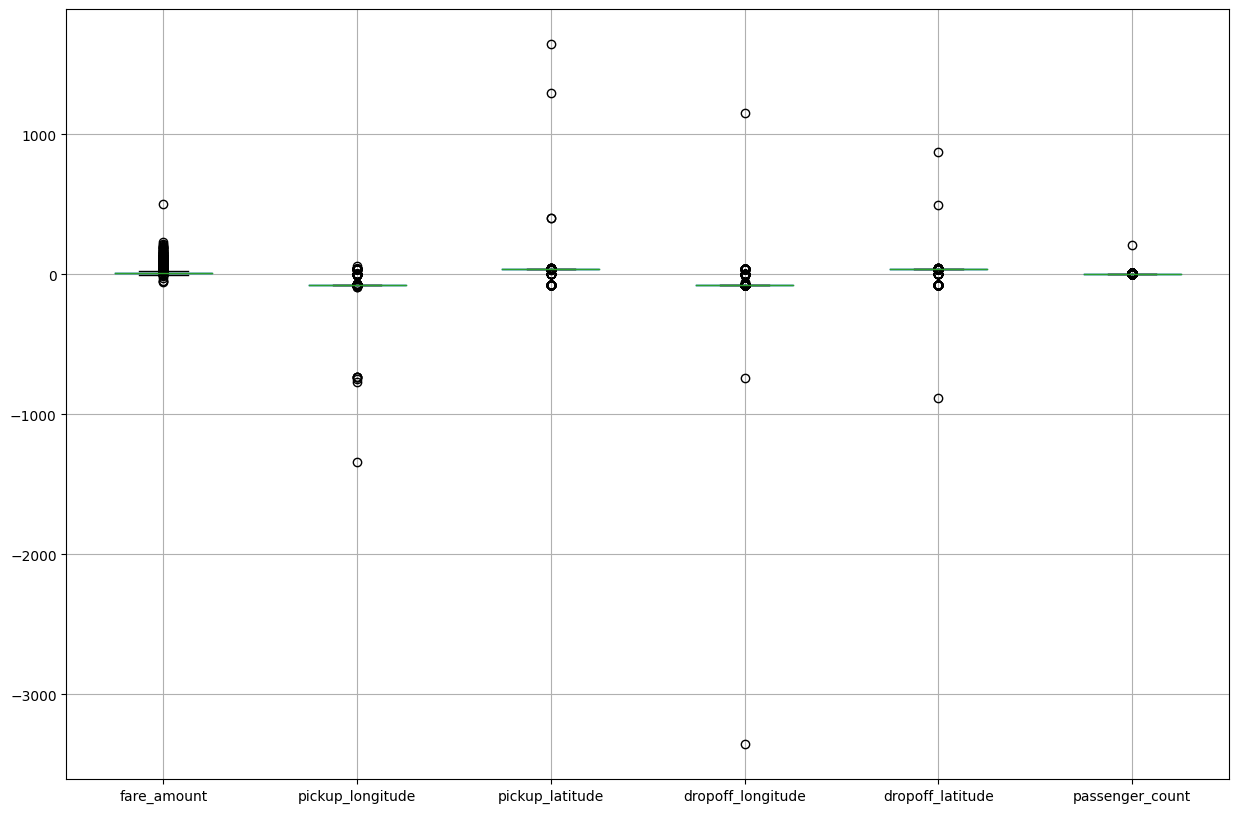

In [11]:
data.boxplot(figsize=(15,10))

Видно, что во многих столбцах есть выбросы. Для их удаления необходимо произвести обработку данных.

## Обработка данных

Удалим Nan значения

In [10]:
data = data.dropna()

Удалим значения, где долгота или широта равна 0

In [ ]:
data = data.drop(data[data['pickup_longitude']==0].index)
data = data.drop(data[data['pickup_latitude']==0].index)

data = data.drop(data[data['dropoff_longitude']==0].index)
data = data.drop(data[data['dropoff_latitude']==0].index)

Удалим выбросы из колонок "fare_amount", "passenger_count"

In [11]:
data = data[(data['fare_amount'] > 0) & (data['fare_amount'] < data['fare_amount'].quantile(0.99))]

In [12]:
data = data[(data['passenger_count'] > 0) & (data['passenger_count'] <= 4)]

Посмотрим на точки, где чаще всего подбирают и высаживают пассажиров

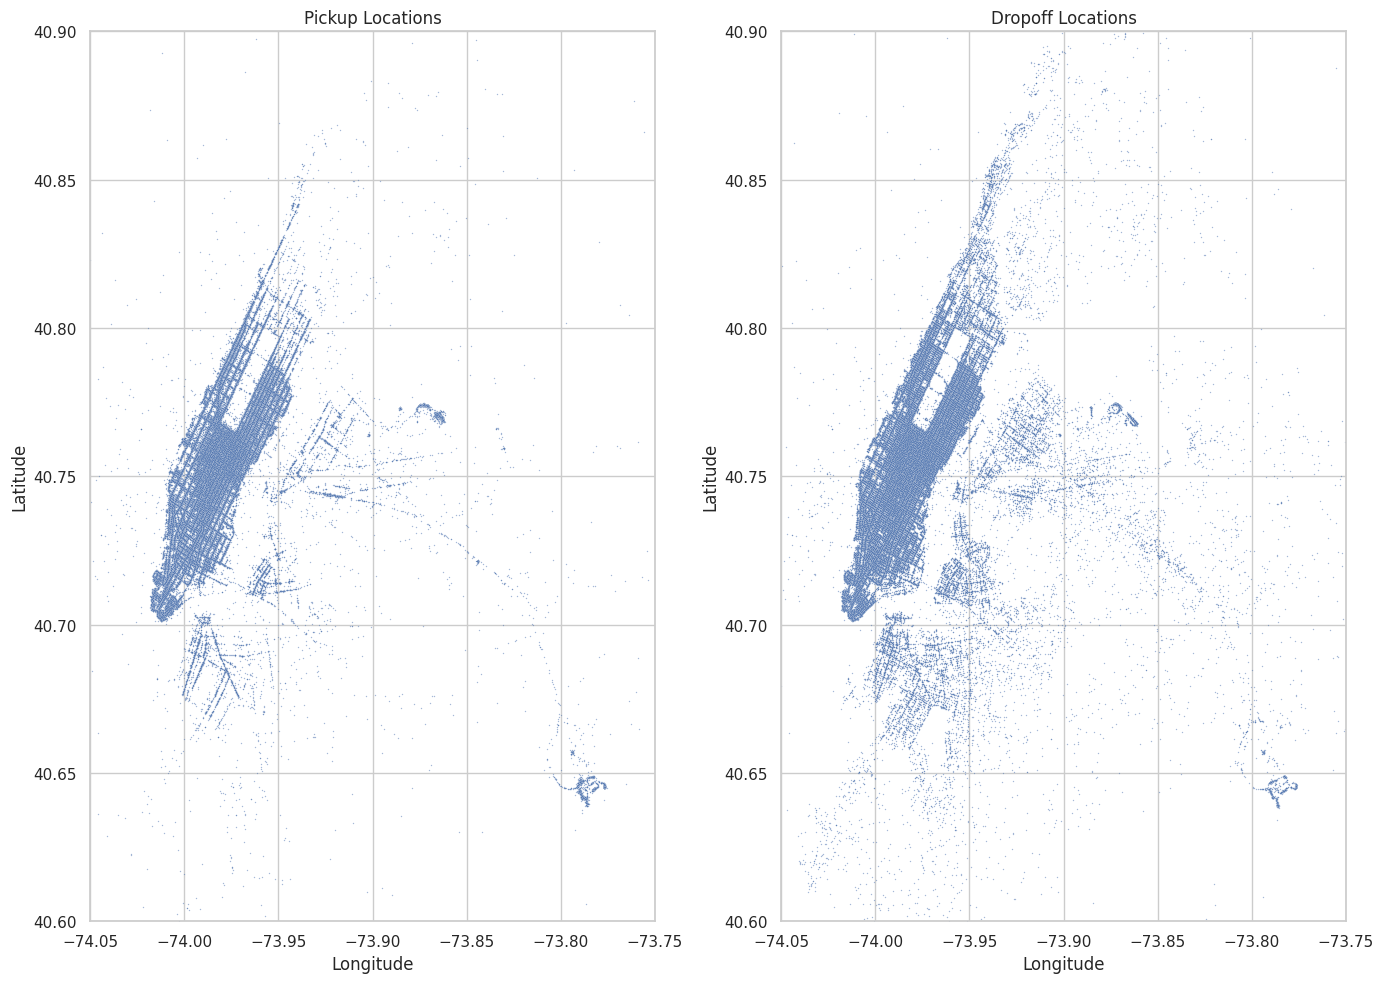

In [13]:
sns.set(style="whitegrid")
plt.figure(figsize=(14, 10))

plt.subplot(1, 2, 1)
sns.scatterplot(x='pickup_longitude', y='pickup_latitude', data=data, s=1, alpha=0.5)
plt.xlim([-74.05, -73.75])
plt.ylim([40.60, 40.9])
plt.title('Pickup Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.subplot(1, 2, 2)
sns.scatterplot(x='dropoff_longitude', y='dropoff_latitude', data=data, s=1, alpha=0.5)
plt.xlim([-74.05, -73.75])
plt.ylim([40.60, 40.9])
plt.title('Dropoff Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.tight_layout()
plt.show()

Так как, на самом деле, датасет содержит в себе, по большей части, поездки в окрестности города Нью-Йорк, удалим все значения, которые не попадают в эту окрестность. 

In [14]:
data = data[(data['pickup_longitude'] >= -76) & (data['pickup_longitude'] <= -70)]
data = data[(data['dropoff_longitude'] >= -76) & (data['dropoff_longitude'] <= -70)]
data = data[(data['pickup_latitude'] >= 39) & (data['pickup_latitude'] <= 45)]
data = data[(data['dropoff_latitude'] >= 39) & (data['dropoff_latitude'] <= 45)]

Выведем матрицу корреляции между столбацами в датасете

In [15]:
data.corr()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
fare_amount,1.000000,0.315623,-0.136106,0.309811,-0.128305,0.016807
pickup_longitude,0.315623,1.000000,0.245020,0.509359,0.204992,-0.007905
pickup_latitude,-0.136106,0.245020,1.000000,0.219299,0.531543,-0.016526
dropoff_longitude,0.309811,0.509359,0.219299,1.000000,0.312409,-0.009262
dropoff_latitude,-0.128305,0.204992,0.531543,0.312409,1.000000,-0.007230
passenger_count,0.016807,-0.007905,-0.016526,-0.009262,-0.007230,1.000000


In [16]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,175453.000000,175453.000000,175453.000000,175453.000000,175453.000000,175453.000000
mean,10.803019,-73.975974,40.751336,-73.974364,40.751482,1.331314
std,8.010583,0.039759,0.032183,0.039442,0.036231,0.679202
min,0.010000,-75.426904,39.514527,-75.458979,39.514527,1.000000
25%,6.000000,-73.992300,40.736716,-73.991568,40.735672,1.000000
50%,8.500000,-73.982162,40.753397,-73.980542,40.753855,1.000000
75%,12.500000,-73.968590,40.767645,-73.965552,40.768362,1.000000
max,52.500000,-71.004193,42.478467,-71.004193,42.464187,4.000000


С помощью библиотеки geopy рассчитаем расстояние для каждой поездки, знаю широту и долготу

In [17]:
from geopy.distance import geodesic

# Функция для подсчета расстояния
def calculate_distance(pickup, dropoff):
    return geodesic(pickup, dropoff).km

# Создадим новый столбец, в который запишем дистацнию
data['distance'] = data.apply(lambda row: calculate_distance((row['pickup_latitude'], row['pickup_longitude']),
                                                             (row['dropoff_latitude'], row['dropoff_longitude'])), axis=1)

Будем рассматривать только поездки не длиннее 10 км, остальные считаем выбросами

In [18]:
data = data[(data['distance'] > 0) & (data['distance'] <= 10)]

Добавим новые столбцы, которые отражают в какой час и какой день недели был сделан заказ.

In [19]:
# Конвертируем тип даты
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])

data['hour'] = data['pickup_datetime'].dt.hour
data['day'] = data['pickup_datetime'].dt.day
data['month'] = data['pickup_datetime'].dt.month
data['day_of_week'] = data['pickup_datetime'].dt.dayofweek
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x > 4 else 0)
data['is_rush_hour'] = data['hour'].apply(lambda x: 1 if (7 <= x <= 9 or 16 <= x <= 19) else 0)

Удалим ненужные столбцы

In [20]:
data = data.drop(['pickup_datetime'], axis=1)

Итоговый датафрейм выглядит так

In [21]:
data

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,hour,day,month,day_of_week,is_weekend,is_rush_hour
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,1.681111,19,7,5,3,0,1
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2.454363,20,17,7,4,0,0
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,5.039603,21,24,8,0,0,0
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,1.661442,8,26,6,4,0,1
8,9.7,-73.975187,40.745767,-74.002720,40.743537,1,2.338560,9,17,2,4,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199994,12.0,-73.983070,40.760770,-73.972972,40.754177,1,1.123897,14,31,1,4,0,0
199995,3.0,-73.987042,40.739367,-73.986525,40.740297,1,0.112128,10,28,10,6,1,0
199996,7.5,-73.984722,40.736837,-74.006672,40.739620,1,1.879635,1,14,3,4,0,0
199998,14.5,-73.997124,40.725452,-73.983215,40.695416,1,3.536552,14,20,5,2,0,0


А его математическая статистика по столбцам так:

In [22]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,hour,day,month,day_of_week,is_weekend,is_rush_hour
count,166286.000000,166286.000000,166286.000000,166286.000000,166286.000000,166286.000000,166286.000000,166286.000000,166286.000000,166286.000000,166286.000000,166286.000000,166286.000000
mean,9.712942,-73.978988,40.752162,-73.977263,40.752077,1.330725,2.697415,13.515317,15.701947,6.271195,3.046252,0.282513,0.344846
std,5.764674,0.026496,0.025759,0.027459,0.028376,0.678958,2.024457,6.501875,8.690589,3.443044,1.942978,0.450223,0.475319
min,0.010000,-75.387785,39.605438,-75.375315,39.607967,1.000000,0.000084,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,6.000000,-73.992441,40.737363,-73.991722,40.736793,1.000000,1.242280,9.000000,8.000000,3.000000,1.000000,0.000000,0.000000
50%,8.100000,-73.982332,40.753612,-73.980950,40.754111,1.000000,2.071384,14.000000,16.000000,6.000000,3.000000,0.000000,0.000000
75%,11.700000,-73.969697,40.767485,-73.967329,40.768199,1.000000,3.528112,19.000000,23.000000,9.000000,5.000000,1.000000,1.000000
max,52.500000,-71.896038,42.478467,-71.836652,42.464187,4.000000,9.999684,23.000000,31.000000,12.000000,6.000000,1.000000,1.000000


# Постановка задачи

Задачей является предсказание цены поездки по вышеописанным признакам. То есть целью является предсказание "fare_amount". Данная задача является задачей регресии, так как необходимо предсказывать числовую величину.

Для решения задачи будем использовать несколько моделей машинного обучения: Linear Regression, Random Forest и Multi-layer Perceptron classifier.

## Обучение модели

Определим, что является признаками, а что целью, которую необходимо предсказывать и запишем их в X и y соответсвенно

In [23]:
X = data.drop('fare_amount', axis=1)
y = data['fare_amount']

Далее разделим выборку на тренировочный и тестовый набор и проведем стандартизацию данных, так как числовые величины в данных имеют разный порядок.

In [24]:
# Разделим выборку на тренировочный и тестовый набор с соотношением 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Так как рассматриваемые рассматриваемые числовые величины имеют разный порядок, 
# используем стандартизацию с помощью с помощью StandartScaler()
scaler = StandardScaler()

# Применим StandardScaler к тренировочному и тестовому наборам данных
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Логистическая регрессия

In [37]:
# Используем линейную регрессию с кросс-валидацией
model_LR = LinearRegression()
cv_scores = cross_val_score(model_LR, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
mean_cv_score = -cv_scores.mean()
print(f'Cross-Validation Mean Squared Error: {mean_cv_score}')

# Обучаем модель на тренировочных данных
model_LR.fit(X_train_scaled, y_train)

# Предсказываем значения для тестовых данных
y_test_pred_LR = model_LR.predict(X_test_scaled)
y_train_pred_LR = model_LR.predict(X_train_scaled)

Cross-Validation Mean Squared Error: 11.278583591824795


### Случайный лес

Далее применим модель случайного леса. Но для подбора наилучших параметров будем использовать GridSearch, чтобы подобрать максимальную грубину дерева (max_depth) и количество деревьев (n_estimators).

In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Модель с наилучшими параметрами
best_rf = grid_search.best_estimator_

# Обучаем эту модель
best_rf.fit(X_train_scaled, y_train)

# Предсказываем значения для тестовой выборки с помощью RandomForest
y_test_pred_RF = best_rf.predict(X_test_scaled)
y_train_pred_RF = best_rf.predict(X_train_scaled)

Лучшей моделью оказалась модель с 300 деревьями и без ограничений на максимальную глубину дерева

In [46]:
best_rf

RandomForestRegressor(n_estimators=300, random_state=42)

### MLP

Также применим модель Multi-layer Perceptron с количеством нейронов 100 в скрытом слое.

In [47]:
from sklearn.neural_network import MLPRegressor

# Инициализируем модель
mlp = MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

# И обучим на тренировочном наборе данных
mlp.fit(X_train_scaled, y_train)

# Predict and evaluate
y_test_pred_MLP = mlp.predict(X_test_scaled)
y_train_pred_MLP = mlp.predict(X_train_scaled)


# Оценка модели и результатов

### Результаты применения линейной регрессии

In [35]:
# Считаем метрики качества модели
mse = mean_squared_error(y_test, y_test_pred_LR)
r2 = r2_score(y_test, y_test_pred_LR)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 10.778056387352986
R-squared: 0.6718623496672745


Так как R^2 метрика равна 0.67 - это значит, что модель, обученная линейной регрессией способна описать 67% данных.

Выведем реальные и предсказанные моделью значения на один график. Также изобразим линию, к которой должны ближе всего располагаться точки.

Text(0, 0.5, 'Predicted Values')

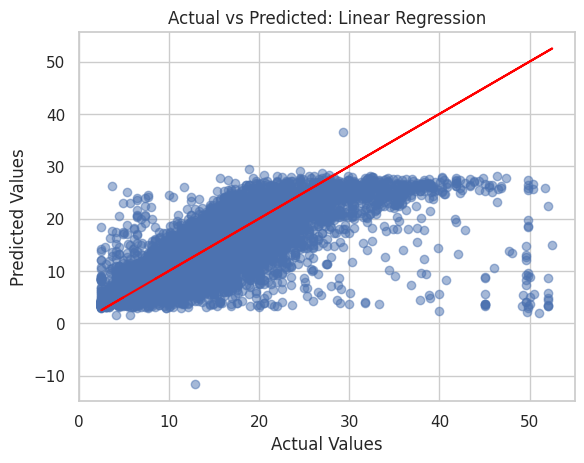

In [36]:
plt.scatter(x=y_test, y=y_test_pred_LR, alpha=0.5)
plt.plot(y_test,y_test, c="red")
plt.title("Actual vs Predicted: Linear Regression")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")

### Результаты применения случайного леса

In [48]:
# Считаем метрики качества модели, обученной с помощью случайного леса

mse = mean_squared_error(y_test, y_test_pred_RF)
r2 = r2_score(y_test, y_test_pred_RF)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 8.358607750583417
R-squared: 0.7455224013721313


Также построим график

Text(0, 0.5, 'Predicted Values')

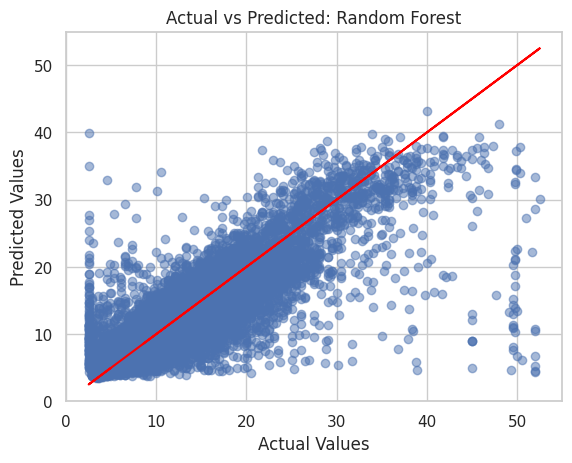

In [49]:
plt.scatter(x=y_test, y=y_test_pred_RF, alpha=0.5)
plt.plot(y_test,y_test, c="red")
plt.title("Actual vs Predicted: Random Forest")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")

### Результаты применения MLP

In [42]:
# Считаем метрики качества модели, обученной с помощью MLP

mse = mean_squared_error(y_test, y_test_pred_MLP)
r2 = r2_score(y_test, y_test_pred_MLP)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 8.602007922242175
R-squared: 0.738112089387458


Text(0, 0.5, 'Predicted Values')

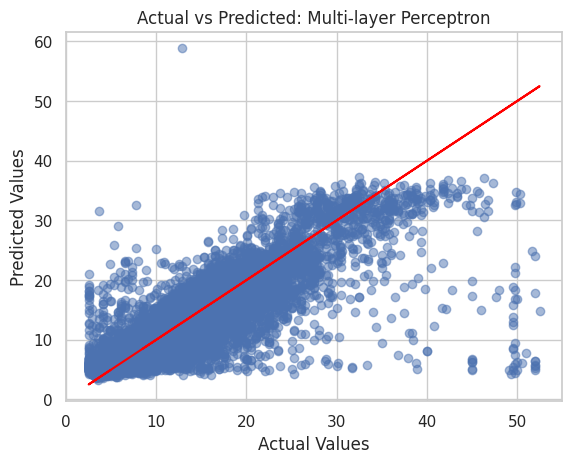

In [43]:
plt.scatter(x=y_test, y=y_test_pred_MLP, alpha=0.5)
plt.plot(y_test,y_test, c="red")
plt.title("Actual vs Predicted: Multi-layer Perceptron")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")

Исходя из обучения моделей, можно сделать вывод, что по R^2 метрике лучше всех справилась модель, обученная Random Forest. Такой же вывод можно сделать и по построенным графикам.

Протестируем обученные модели, взяв случайный пример из датасета. Для начала напишем функцию:

In [101]:
def predict_single_sample(model, scaler, sample):
    sample_scaled = scaler.transform([sample])  # Стандартизируем данные
    prediction = model.predict(sample_scaled)  # Предсказываем значение цены
    return prediction[0]

Случайным образом выбираем пример из датасета:

In [102]:
test_sample = data.sample() # Берем случайную строку из тренировочного датасета

y_true = test_sample['fare_amount'] 
X_test_sample = test_sample.drop(columns=['fare_amount']) # Убираем целевой столбец

Предсказываем значение цены для выбранной строки с помощью Linear Regression

In [103]:
predicted_fare_LR = predict_single_sample(model_LR, scaler, X_test_sample.values.squeeze())
print(f'Predicted Fare Amount (Linear Regression): {np.round(predicted_fare_LR,3)}')

Predicted Fare Amount (Linear Regression): 6.327


Теперь с помощью Random Forest

In [104]:
# Предсказываем значение цены для этой строки

predicted_fare_RF = predict_single_sample(best_rf, scaler, X_test_sample.values.squeeze())
print(f'Predicted Fare Amount (Random Forest): {np.round(predicted_fare_RF, 3)}')

Predicted Fare Amount (Random Forest): 5.467


И через MLP

In [105]:
predicted_fare_MLP = predict_single_sample(mlp, scaler, X_test_sample.values.squeeze())
print(f'Predicted Fare Amount (MLP): {np.round(predicted_fare_MLP,3)}')

Predicted Fare Amount (MLP): 5.936


А правильное значение цены для этого примера выглядит так:

In [106]:
print(f'Real Fare Amount: {y_true.values.squeeze()}')

Real Fare Amount: 5.3


In [107]:
error_LR = np.round((predicted_fare_LR - y_true.values.squeeze())**2,3)
error_RF = np.round((predicted_fare_RF - y_true.values.squeeze())**2,3)
error_MLP = np.round((predicted_fare_MLP - y_true.values.squeeze())**2,3)

print(f'Error for Linear Regression: {error_LR}')
print(f'Error for Random Forest: {error_RF}')
print(f'Error for MLP: {error_MLP}')

Error for Linear Regression: 1.054
Error for Random Forest: 0.028
Error for MLP: 0.404


In [109]:
from tabulate import tabulate
print(tabulate([['Linear Regression', np.round(predicted_fare_LR,3),y_true.values.squeeze(),error_LR], 
                ['Random Forest', np.round(predicted_fare_RF,3),y_true.values.squeeze(),error_RF], 
                ['Multi-layer Perceptron', np.round(predicted_fare_MLP,3),y_true.values.squeeze(),error_MLP]],
                headers=['Модель', 'Предсказанное значение цены', 'Реальное значение', 'Ошибка MSE']))

Модель                    Предсказанное значение цены    Реальное значение    Ошибка MSE
----------------------  -----------------------------  -------------------  ------------
Linear Regression                               6.327                  5.3         1.054
Random Forest                                   5.467                  5.3         0.028
Multi-layer Perceptron                          5.936                  5.3         0.404


Таким образом, модель, обученная с помощью Random Forest является наилучшей из рассмотренных для предсказания цены поездки в Uber. Но стоит отметить, что результат обучения можно улучшить, если собрать еще данные о поездках, например, добавив информацию о марке и классе автомобиля такси или о погодных условиях в городе на момент поездки. 